# Training data

## Reading the data

In this notebook we will load the data that is used for training and convert it to the input representation that we need to train the network.

In [31]:
from pathlib import Path

path_strokefiles = Path("./../../data/raw_data/strokefiles")
path_textfiles = Path("./../../data/raw_data/textfiles")

In [32]:
import os

textfile_paths = [Path(dirpath + "/" + filenames[0])
                  for (dirpath, dirnames, filenames) in os.walk(path_textfiles)
                  if filenames != []] 

print(textfile_paths[:3])

[PosixPath('../../data/raw_data/textfiles/n03/n03-188/n03-188z.txt'), PosixPath('../../data/raw_data/textfiles/n03/n03-196/n03-196z.txt'), PosixPath('../../data/raw_data/textfiles/n03/n03-248/n03-248z.txt')]


In [33]:
import re

example_textfile_path = textfile_paths[0]
print(f'exmaple path = {example_textfile_path}\n')

def get_file_lines(textfile_path):
    f = open(textfile_path) 
    content = f.read()
    lines = re.search("CSR:\s*([^~]*)", content).group(1).strip().split("\n")
    return lines
    
example_textlines = get_file_lines(example_textfile_path)
print(example_textlines)

exmaple path = ../../data/raw_data/textfiles/n03/n03-188/n03-188z.txt

['But no! She ai nt got sense', 'enough to see that, even if she is Dan', "Hawley's daughter, which personally I think she", 'aint. " " What do you mean by that, Constable?']


In [34]:
stroke_paths = [(dirpath, filenames)
                for (dirpath, dirnames, filenames) in os.walk(path_strokefiles)
                if filenames != []]

print(stroke_paths[:3])

[('../../data/raw_data/strokefiles/n03/n03-188', ['n03-188z-03.xml', 'n03-188z-02.xml', 'n03-188z-04.xml', 'n03-188z-01.xml']), ('../../data/raw_data/strokefiles/n03/n03-196', ['n03-196z-07.xml', 'n03-196z-05.xml', 'n03-196z-03.xml', 'n03-196z-02.xml', 'n03-196z-01.xml', 'n03-196z-04.xml', 'n03-196z-08.xml', 'n03-196z-06.xml']), ('../../data/raw_data/strokefiles/n03/n03-248', ['n03-248z-04.xml', 'n03-248z-02.xml', 'n03-248z-01.xml', 'n03-248z-03.xml'])]


In [35]:
def get_stroke_paths(textfile_path):
    strokefiles_root_folder = path_strokefiles / textfile_path.parts[5] / textfile_path.parts[6]
    
    if not strokefiles_root_folder.is_dir():
        return None
    
    m = re.search("(.*?)-(.*)", textfile_path.stem)
        
    res = [strokefiles_root_folder / filename for filename in sorted(os.listdir(strokefiles_root_folder))         
           if re.search("(.*?)-(.*?)-.*", filename).groups() == m.groups()]

    if len(res) == 0:
        return None
    
    return res

example_textline_strokefile_paths = get_stroke_paths(example_textfile_path)
print(example_textline_strokefile_paths)

[PosixPath('../../data/raw_data/strokefiles/n03/n03-188/n03-188z-01.xml'), PosixPath('../../data/raw_data/strokefiles/n03/n03-188/n03-188z-02.xml'), PosixPath('../../data/raw_data/strokefiles/n03/n03-188/n03-188z-03.xml'), PosixPath('../../data/raw_data/strokefiles/n03/n03-188/n03-188z-04.xml')]


In [36]:
import xml.etree.ElementTree as ET
import numpy as np

def read_file(filename):
    root = ET.parse(filename).getroot()
    
    strokes = [[[point.attrib["x"], point.attrib["y"], point.attrib["time"]]
                 for point in stroke.findall("./Point")]
                for stroke in root.findall("./StrokeSet/Stroke")]

    max_stroke_len = max(len(r) for r in strokes)
    
    s = np.zeros((len(strokes), max_stroke_len, 3))
    s[:, :, 2] -= 1

    for i, row in enumerate(strokes):
        s[i, :len(row)] = row

    return s

example_textline_strokes = [read_file(file) for file in example_textline_strokefile_paths]

But no! She ai nt got sense


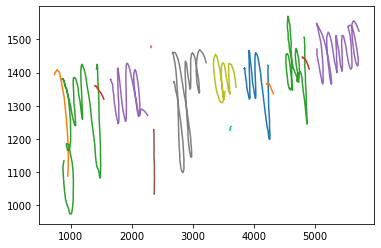

enough to see that, even if she is Dan


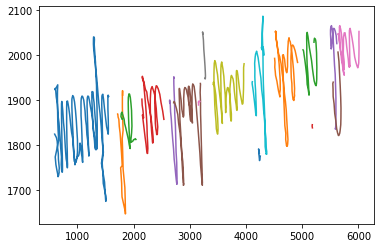

Hawley's daughter, which personally I think she


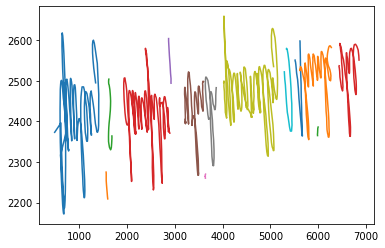

aint. " " What do you mean by that, Constable?


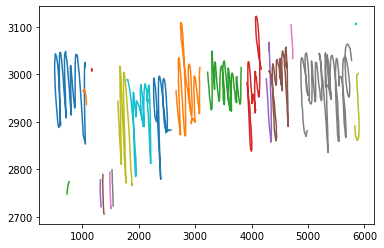

In [37]:
import matplotlib.pyplot as plt

def plot_strokes(strokes):
    for stroke in strokes:
        plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])

    plt.show()
        
for (textline, textline_strokes) in zip(example_textlines, example_textline_strokes):
    print(textline)
    plot_strokes(textline_strokes)

## Encoding the data

In [38]:
def get_alphabet(textfile_paths):
    all_chars = set()
    
    for file in textfile_paths:
        with open(file) as f:
            content = f.read()
            text_chars = set(re.search("CSR:\s*([^~]*)", content).group(1).strip())
            
            all_chars = all_chars.union(text_chars)
        
    return list(all_chars)

alphabet = get_alphabet(textfile_paths)

In [39]:
def encode_textline(textline, alphabet):
    return [alphabet.index(c) for c in textline]

def decode_textline(encodedline, alphabet):
    return [alphabet[v] for v in encodedline]

In [40]:
# def encode_textline(textline):
#     return [ord(c) for c in textline]

# def decode_textline(encodedline):
#     return [chr(v) for v in encodedline]

In [41]:
def normalize_strokes(strokes):
    ustrokes = [np.unique(stroke[:, :2], return_index=True, axis=0)[1] for stroke in strokes]
    max_stroke_len = max(len(r) for r in ustrokes)

    normalized_strokes = np.zeros((len(ustrokes), max_stroke_len, 3))
    normalized_strokes[:, :, 2] -= 1

    for i, row in enumerate(ustrokes):
        normalized_strokes[i, :len(row)] = strokes[i, np.sort(row)]

    non_ragged = normalized_strokes[:, :, 2] >= 0
    normalized_strokes[non_ragged] -= [normalized_strokes[0, 0, 0], np.amax(normalized_strokes[:, :, 1]), normalized_strokes[0, 0, 2]]
    normalized_strokes[non_ragged] /= [-np.amin(normalized_strokes[:, :, 1]), np.amin(normalized_strokes[:, :, 1]), 1]

    return normalized_strokes

In [42]:
def sample_line(p0, p1, delta=0.05):
    l = ((p1[0]-p0[0])**2 + (p1[1]-p0[1])**2)**0.5
    num = int(l/delta)
    
    if num == 0:
        return [p0]
    
    sampled_xs = np.linspace(p0[0], p1[0], num)
    sampled_ys = np.linspace(p0[1], p1[1], num)
    sampled_timestamps = np.linspace(p0[2], p1[2], num)

    return np.stack((sampled_xs, sampled_ys, sampled_timestamps), axis=1).tolist()

def resample_stroke(stroke):
    resampled_stroke = []
    
    for i, _ in enumerate(stroke[stroke[:, 2] >= 0][:-1]):
        resampled_stroke.extend(sample_line(stroke[i], stroke[i+1]))
        
    return resampled_stroke

def resample_strokes(strokes):
    rs = [resample_stroke(stroke) for stroke in strokes]
    max_stroke_len = max(len(r) for r in rs)

    resampled_strokes = np.zeros((len(rs), max_stroke_len, 3))
    resampled_strokes[:, :, 2] -= 1

    for i, row in enumerate(rs):
        if row:
            resampled_strokes[i, :len(row)] = row
    
    return resampled_strokes

In [57]:
def add_extra_params(strokes):
#     directions = np.apply_along_axis(lambda x: int(x[x >= 0][0] < x[x >= 0][-1]), 1, strokes[:,:,1])
#     directions = np.tile(np.expand_dims(directions, axis=0).transpose(), (1, strokes.shape[1]))
#     rtps = np.append(strokes, np.expand_dims(directions, axis=2), axis=2)
#     rtps = np.append(rtps, np.zeros((strokes.shape[0], strokes.shape[1], 1)), axis=2)
#     rtps[:, 0, 4] = 1
    rtps = np.append(strokes, np.zeros((strokes.shape[0], strokes.shape[1], 1)), axis=2)
    rtps[:, 0, 3] = 1
    touch_points = rtps[rtps[:, :, 2] >= 0].tolist()
    touch_points = np.array(touch_points)
    
    diffs = np.insert(np.diff(touch_points, axis=0)[:,:3], 0, np.array([0, 0, 0]), axis=0)
    return np.append(diffs, np.expand_dims(touch_points[:,3], -1), axis=1)

def add_extra_params_test(strokes):
#     directions = np.apply_along_axis(lambda x: int(x[x >= 0][0] < x[x >= 0][-1]), 1, strokes[:,:,1])
#     directions = np.tile(np.expand_dims(directions, axis=0).transpose(), (1, strokes.shape[1]))
#     rtps = np.append(strokes, np.expand_dims(directions, axis=2), axis=2)
#     rtps = np.append(rtps, np.zeros((strokes.shape[0], strokes.shape[1], 1)), axis=2)
#     rtps[:, 0, 4] = 1
    rtps = np.append(strokes, np.zeros((strokes.shape[0], strokes.shape[1], 1)), axis=2)
    rtps[:, 0, 3] = 1
    touch_points = rtps[rtps[:, :, 2] >= 0].tolist()
    touch_points = np.array(touch_points)
    
#     diffs = np.insert(np.diff(touch_points, axis=0)[:,:3], 0, np.array([0, 0, 0]), axis=0)
#     return np.append(diffs, np.expand_dims(touch_points[:,3], -1), axis=1)
    return touch_points

In [61]:
data = []
target = []

for i, textfile_path in enumerate(textfile_paths[:2]):
    if i % 100 == 0:
        print(i/len(textfile_paths))

    textline_strokefile_paths = get_stroke_paths(textfile_path)
    
    if not textline_strokefile_paths:
        continue

#     lines = [encode_textline(line, alphabet) for line in get_file_lines(textfile_path)]
#     strokes = [add_extra_params(resample_strokes(normalize_strokes(read_file(textfile_stroke_path))))
#                for textfile_stroke_path in textline_strokefile_paths]
    
    test_1 = add_extra_params(resample_strokes(normalize_strokes(read_file(textline_strokefile_paths[0]))))
    test_2 = add_extra_params_test(resample_strokes(normalize_strokes(read_file(textline_strokefile_paths[0]))))
  
    print("1:", test_1)
    print("2:", test_2)
    if len(lines) != len(strokes):
        print(textfile_path)

    data.extend(strokes)
    target.extend(lines)

0.0
1: [[ 0.          0.          0.          1.        ]
 [ 0.00167785 -0.02013423  0.01        0.        ]
 [ 0.00838926 -0.0352349   0.02        0.        ]
 ...
 [ 0.02852349 -0.0033557   0.02        0.        ]
 [ 0.03691275  0.00838926  0.02        0.        ]
 [ 0.04697987  0.01677852  0.01        0.        ]]
2: [[1.67785235e-02 8.08724832e-01 6.99999984e-02 1.00000000e+00]
 [1.84563758e-02 7.88590604e-01 8.00000001e-02 0.00000000e+00]
 [2.68456376e-02 7.53355705e-01 9.99999996e-02 0.00000000e+00]
 ...
 [7.88255034e+00 2.34899329e-02 2.04000000e+01 0.00000000e+00]
 [7.91946309e+00 3.18791946e-02 2.04200000e+01 0.00000000e+00]
 [7.96644295e+00 4.86577181e-02 2.04300000e+01 0.00000000e+00]]
1: [[ 0.          0.          0.          1.        ]
 [ 0.05217087 -0.04236695  0.0025      0.        ]
 [ 0.05217087 -0.04236695  0.0025      0.        ]
 ...
 [ 0.01120448  0.00420168  0.02        0.        ]
 [-0.0070028  -0.0070028   0.01        0.        ]
 [ 0.00140056  0.00280112  0.02

In [53]:
print(len(data), len(target))

11983 11983


In [54]:
sample = 0

def plot_stroke(stroke):
    plt.scatter(stroke[:, 0][stroke[:, 4] == 1], stroke[:, 1][stroke[:, 4] == 1])
    plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])
    plt.show()
    
plot_stroke(data[sample])

print(decode_textline(target[sample]))

IndexError: index 4 is out of bounds for axis 1 with size 4

## Storing the data

In [55]:
def pad_data(l, value=0, width=None):
    max_len = max(len(item) for item in l)
    
    if width:
        padded_numpy_array = np.full((len(l), max_len, width), value, dtype=np.float32)
    else:
        padded_numpy_array = np.full((len(l), max_len), value, dtype=np.float32)
    
    for i, row in enumerate(l):
        padded_numpy_array[i, :len(row)] = row
    
    return padded_numpy_array

# def pad_data(l, value=0, width=None):
#     max_len = max(len(item) for item in l)
    
#     if width:
#         padded_numpy_array = np.fu((len(l), max_len, width))
#     else:
#         padded_numpy_array = np.zeros((len(l), max_len))
    
#     for i, row in enumerate(l):
#         padded_numpy_array[i, :len(row)] = row
        
#     return padded_numpy_array
        
features = pad_data(data, width=4)
target = pad_data(target, value=len(alphabet))

print(features.shape, target.shape)

np.save("../../data/processed_data/rtp_features_test", features)
np.save("../../data/processed_data/rtp_target_test", target)

(11983, 1713, 4) (11983, 64)
